### Implementation of M/M/n queue system

In [74]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

In [2]:
class Request:
    """Represents a single request in a M/M/n queue"""
    def __init__(self, request_id, arrival_time, service_time):
        self.request_id = request_id
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.wait_time = None

    def log_wait(self, wait_time):
        """Log waiting time"""
        self.wait_time = wait_time

# Generate service times using np.random.choice
def generate_service_time(probabilities, scales):
    choice = np.random.choice(len(probabilities), p=probabilities)
    return np.random.exponential(scale=1/scales[choice])

In [3]:
class MMNqueue:
    """Simulates an M/M/n queue."""
    def __init__(self, simpy_env, num_servers, service_probabilities, service_scales, num_requests, arrival_rate, scheduler_type="FIFO"):
        self.env = simpy_env
        self.num_servers = num_servers
        self.service_probabilities = service_probabilities
        self.service_scales = service_scales
        self.arrival_rate = arrival_rate

        match scheduler_type:
            case "FIFO" : self.pool = simpy.Resource(self.env, capacity=num_servers)
            case "SJF"  : self.pool = simpy.PriorityResource(self.env, capacity=num_servers) 


        # Request information
        self.completed_requests = 0
        self.requests = []
        self.num_requests = num_requests

    def generate_request(self, request_id):
        """Generate a new request."""
        arrival_time = self.env.now
        service_time = generate_service_time(self.service_probabilities, self.service_scales)
        return Request(request_id, arrival_time, service_time)

    def handle_request(self, request):
        """Handle requests using the selected resource (FIFO or SJF)."""
        if isinstance(self.pool, simpy.PriorityResource):
            # SJF: Use priority based on service time
            with self.pool.request(priority=request.service_time) as req:
                yield req
                wait_time = self.env.now - request.arrival_time
                request.log_wait(wait_time)
                yield self.env.timeout(request.service_time)
            
            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1
        else:
            # FIFO: No priority, just use FIFO
            with self.pool.request() as req:
                yield req
                wait_time = self.env.now - request.arrival_time
                request.log_wait(wait_time)
                yield self.env.timeout(request.service_time)

            self.requests.append(request)  # Store the processed request
            self.completed_requests += 1

    def arrival_process(self):
        """Simulate the arrival process of requests."""
        request_id = 0
        while self.completed_requests < self.num_requests:
            yield self.env.timeout(np.random.exponential(1 / self.arrival_rate))  # Inter-arrival time
            request = self.generate_request(request_id)
            request_id += 1
            # Add request to the appropriate resource queue (based on FIFO/SJF)
            self.env.process(self.handle_request(request))  # Process the request


In [4]:
def run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO"):
    # Initialize the simulation environment
    env = simpy.Environment()

    # Initialize the MMNqueue with the given parameters
    mmn_queue = MMNqueue(
        simpy_env=env,
        num_servers=num_servers,
        service_probabilities=service_probabilities,
        service_scales=service_scales,
        num_requests=num_requests,
        arrival_rate=arrival_rate,
        scheduler_type=scheduler_type,
    )

    # Start the arrival and handling processes
    env.process(mmn_queue.arrival_process())

    # Run the simulation
    env.run()

    # Collect and return simulation statistics
    wait_times = [req.wait_time for req in mmn_queue.requests if req.wait_time is not None]
    service_times = [req.service_time for req in mmn_queue.requests]

    return {
        "wait_times": wait_times,
        "service_times": service_times,
        "num_completed_requests": len(mmn_queue.requests),
        "num_total_requests": num_requests,
    }


In [5]:
def calculate_theoretical_waiting_time(lamda, mu, n):
    return lamda / (n * mu**2 - lamda * mu)

In [ ]:
# Parameters
num_requests = 100000
num_servers = 2
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates

burn_in_percentage = 0.05
burn_in_count = int(num_requests * burn_in_percentage)

# Run FIFO simulation
fifo_result = run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO")
print(f"FIFO Results: {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}") 
print(f"Theoretical Expectation under FIFO: {calculate_theoretical_waiting_time(arrival_rate, service_scales[0], num_servers):.4f}")

# Run SJF simulation
sjf_result = run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="SJF")
print(f"SJF Results: {np.mean(sjf_result["wait_times"][burn_in_count:]):.4f}")


In [ ]:
# Parameters
num_requests = 100000
num_servers = 1
arrival_rate = 1/5  # Inter-arrival time
service_probabilities = [0.75, 0.25]  # Example probabilities for different service times
service_scales = [1/1, 1/5]  # Example service rates

burn_in_percentage = 0.05
burn_in_count = int(num_requests * burn_in_percentage)

# Run FIFO simulation
fifo_result = run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO")
print(f"FIFO Results: {np.mean(fifo_result["wait_times"][burn_in_count:]):.4f}") 

FIFO Results: 2.3521


In [75]:
def simulation_wrapper(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO"):
    return run_simulation(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO")

def simulate_parallel(n_runs, num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO"):
    results = Parallel(n_jobs=-1)(delayed(simulation_wrapper)(num_requests, num_servers, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO") for _ in range(n_runs))
    return results

In [111]:
# Parameters
num_requests = 1000000
num_servers = 4
arrival_rates = 1/5  # Inter-arrival time
service_probabilities = [1]  # Example probabilities for different service times
service_scales = [1/4.5]  # Example service rates
burn_in_percentage = 0.1
burn_in_count = int(num_requests * burn_in_percentage)
num_simulations = 100

sim_means = np.zeros((num_servers, num_simulations))
sim_stds = np.zeros((num_servers, num_simulations))

for j in range(num_servers):
    fifo_result = simulate_parallel(num_simulations, num_requests, j+1, arrival_rate, service_probabilities, service_scales, scheduler_type="FIFO")
    
    for i in range(num_simulations):
        sim_means[j, i] = np.mean(fifo_result[i]["wait_times"][burn_in_count:])
        sim_stds[j ,i] = np.std(fifo_result[i]["wait_times"][burn_in_count:])

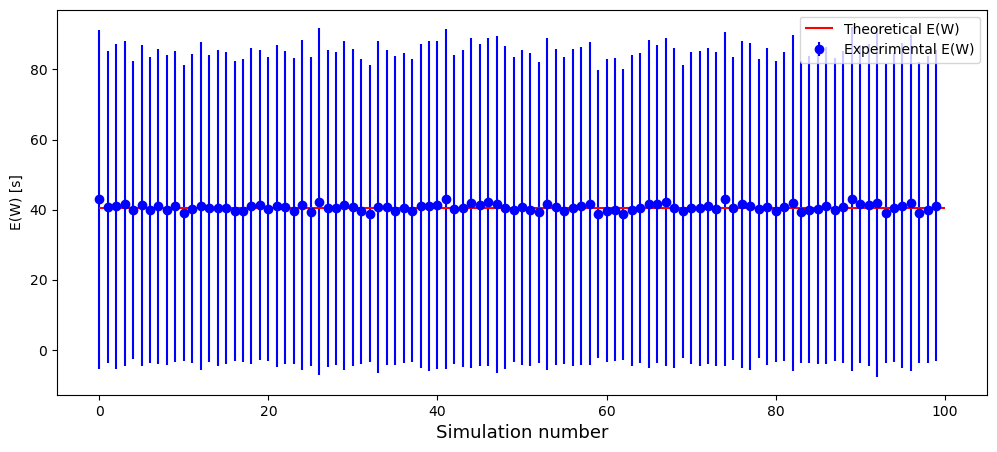

In [112]:
plt.figure(figsize=(12, 5))
plt.errorbar(range(num_simulations), sim_means[0], yerr=sim_stds[0], fmt = 'o', color='blue', label='Experimental E(W)')
plt.hlines(calculate_theoretical_waiting_time(arrival_rate, service_scales[0], 1), xmin=0, xmax=num_simulations, color='red', label='Theoretical E(W)')
plt.legend()
plt.xlabel('Simulation number', fontsize=13)
plt.ylabel('E(W) [s]')
plt.show()

In [ ]:
x_theoretical = np.linspace(1, 4.5, 100)
E_theoretical = calculate_theoretical_waiting_time(arrival_rate, service_scales[0], x_theoretical)

In [113]:
means = np.mean(sim_means, axis=1)
stds = np.std(sim_stds, axis=1)

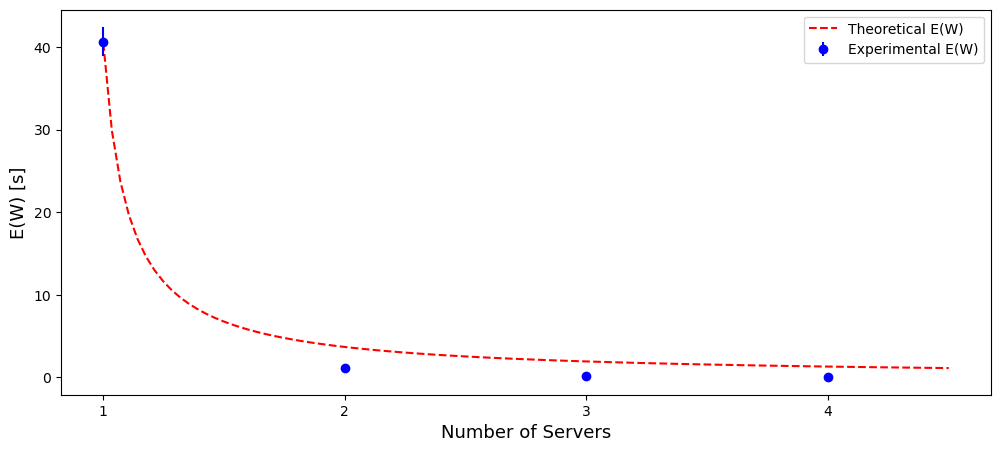

In [114]:
plt.figure(figsize=(12, 5))
plt.plot(x_theoretical, E_theoretical, ls='dashed', color='red', label='Theoretical E(W)')
plt.errorbar(range(1, 5), means, stds, fmt='o', color='blue', label=fr'Experimental E(W)')
plt.xlabel('Number of Servers', fontsize=13)
plt.ylabel('E(W) [s]', fontsize=13)
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()